In [1]:
import torch
import triton
import torch.nn.functional as F
import sys
sys.path.append('/home/roark/Documents/7_cuda/triton/rk/rk_triton')
from functions.RmsNorm import RMSNormFused

DEVICE = triton.runtime.driver.active.get_active_torch_device()
rmsnorm = RMSNormFused.apply

## Test

In [2]:
def test_rmsnorm(M, N, dtype=torch.float32, eps=1e-6, device=DEVICE):
    x_shape = (M, N)
    w_shape = (N, )
    weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    x.requires_grad_(True) # 为了不track上一行x构造式中的-, +, *计算
    dy = 0.1 * torch.randn_like(x)
    # fwd
    triton_y = rmsnorm(x, weight, eps)
    torch_y = F.rms_norm(x, w_shape, weight, eps).to(dtype)
    # bwd
    triton_y.backward(dy)
    triton_dx, triton_dw = [k.grad.clone() for k in [x, weight]]
    x.grad, weight.grad = None, None
    torch_y.backward(dy)
    torch_dx, torch_dw = [k.grad.clone() for k in [x, weight]]
    print(torch.max(torch.abs(torch_y - triton_y)).item())
    print(torch.max(torch.abs(torch_dx - triton_dx)).item())
    print(torch.max(torch.abs(torch_dw - triton_dw)).item())
    assert torch.allclose(torch_y , triton_y , atol=1e-2)
    assert torch.allclose(torch_dx, triton_dx, atol=1e-2)
    assert torch.allclose(torch_dw, triton_dw, atol=1e-2)

In [3]:
test_rmsnorm(300, 1024, torch.float16)

0.0009765625
0.0001220703125
0.00390625


In [4]:
torch.manual_seed(0)
shape = (200, 2000)
x = torch.randn(shape, dtype=torch.float32).to(DEVICE)
w = torch.ones(shape[-1]).to(x.dtype).to(DEVICE) # special value of weight

triton_y = rmsnorm(x, w, )
torch_y = F.rms_norm(x, normalized_shape=(shape[-1],), weight=w, eps=1e-8)
print('Max: ', torch.max(torch.abs(triton_y-torch_y)).item())
print('Mean: ', torch.mean(torch.abs(triton_y-torch_y)).item())

error = torch.abs(triton_y - torch_y)
print("Number of exact matches:", (error == 0).sum().item(), "out of", error.numel())
print("Number of not matches:", (error != 0).sum().item(), "out of", error.numel())

assert torch.allclose(triton_y, torch_y, atol=1e-4)

Max:  4.76837158203125e-07
Mean:  1.2120645820345999e-08
Number of exact matches: 338452 out of 400000
Number of not matches: 61548 out of 400000


## Benchmark

In [5]:
# prepare the compiled version of rmsnorm function

@torch.compile
def torch_rmsnorm(x, w_shape, weight, eps):
    return F.rms_norm(x, w_shape, weight, eps)

In [7]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals=[512 * i for i in range(2, 32)],
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['Triton', 'Torch'],
        styles=[('blue', '-'), ('green', '-')],
        ylabel='GB/s',
        plot_name='layer-norm-backward',
        args={'M': 4096, 'dtype': torch.float16, 'mode': 'forward'},
    ))
def bench_layer_norm(M, N, dtype, provider, mode='backward', eps=1e-5, device=DEVICE):
    # create data
    x_shape = (M, N)
    w_shape = (x_shape[-1], )
    weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    dy = .1 * torch.randn_like(x)
    x.requires_grad_(True)
    quantiles = [0.5, 0.2, 0.8]

    def y_fwd():
        if provider == "torch":
            return torch_rmsnorm(x, w_shape, weight, eps)  # noqa: F811, E704
        if provider == "triton":
            return rmsnorm(x, weight, eps)

    # forward pass
    if mode == 'forward':
        gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(y_fwd, quantiles=quantiles, rep=500)
    # backward pass
    if mode == 'backward':
        y = y_fwd()
        gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)  # noqa: F811, E704
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), quantiles=quantiles,
                                                     grad_to_none=[x], rep=500)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

layer-norm-backward:
          N      Triton        Torch
0    1024.0  759.837664   737.395217
1    1536.0  835.740696  1143.069767
2    2048.0  871.634274   976.327720
3    2560.0  862.315762   830.094980
4    3072.0  880.662944   865.161721
5    3584.0  892.947911   875.063465
6    4096.0  884.874304   874.177535
7    4608.0  900.494682   873.813311
8    5120.0  905.193391   883.830074
9    5632.0  913.683129   892.474178
10   6144.0  897.241321   898.009732
11   6656.0  913.883618   893.750869
12   7168.0  922.114564   895.344278
13   7680.0  922.176388   897.958428
14   8192.0  920.005260   900.838476
15   8704.0  919.044770   897.211217
16   9216.0  924.126868   900.494682
17   9728.0  925.271448   902.307226
18  10240.0  924.996495   902.855142
19  10752.0  921.034616   901.649982
20  11264.0  925.634852   901.683579
21  11776.0  927.871944   906.118437
22  12288.0  928.765294   905.636384
23  12800.0  926.565804   902.699741
24  13312.0  926.429806   904.544674
25  13824.0  928.

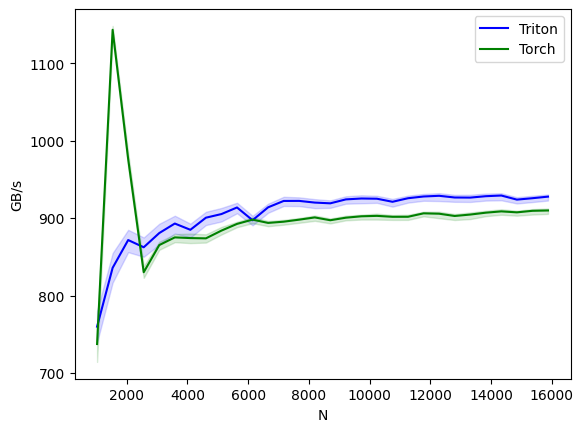

In [8]:
bench_layer_norm.run(save_path='.', print_data=True)

In [9]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals=[512 * i for i in range(2, 32)],
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['Triton', 'Torch'],
        styles=[('blue', '-'), ('green', '-')],
        ylabel='GB/s',
        plot_name='layer-norm-backward',
        args={'M': 4096, 'dtype': torch.float16, 'mode': 'backward'},
    ))
def bench_layer_norm(M, N, dtype, provider, mode='backward', eps=1e-5, device=DEVICE):
    # create data
    x_shape = (M, N)
    w_shape = (x_shape[-1], )
    weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    dy = .1 * torch.randn_like(x)
    x.requires_grad_(True)
    quantiles = [0.5, 0.2, 0.8]

    def y_fwd():
        if provider == "torch":
            return torch_rmsnorm(x, w_shape, weight, eps)  # noqa: F811, E704
        if provider == "triton":
            return rmsnorm(x, weight, eps)

    # forward pass
    if mode == 'forward':
        gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(y_fwd, quantiles=quantiles, rep=500)
    # backward pass
    if mode == 'backward':
        gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)  # noqa: F811, E704
        # 由于torch.compile之后，torch_rmsnorm不支持retain_graph，所以retain_graph取False
        # 但由于benchmark要做多次backward，所以只好每次backward前都重新做一遍forward来构造graph
        # 所以这里的lambda函数用了 'y_fwd().backward()'
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: y_fwd().backward(dy, retain_graph=False), quantiles=quantiles,
                                                     grad_to_none=[x], rep=500)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

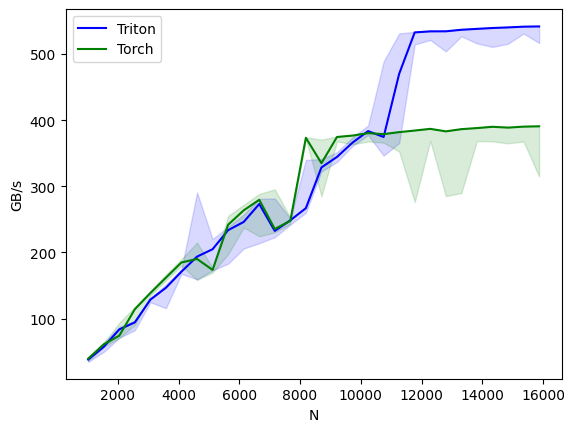

In [10]:
bench_layer_norm.run(save_path='.', print_data=False)